In [1]:
from blockchain.simnet import SimNet
from blockchain.transaction import *
from blockchain.utils import *

In [2]:
nets_6h = [ 
    SimNet(
        simulation_time=21600, coins_amount=10000,
        num_proposer_nodes=20, num_relay_nodes=30, num_greedy_proposers=0
    ),
    SimNet(
        simulation_time=21600, coins_amount=10000,
        num_proposer_nodes=20, num_relay_nodes=30, num_greedy_proposers=5
    ),
    SimNet(
        simulation_time=21600, coins_amount=10000,
        num_proposer_nodes=20, num_relay_nodes=30, num_greedy_proposers=10
    ), 
    SimNet(
        simulation_time=21600, coins_amount=10000,
        num_proposer_nodes=20, num_relay_nodes=30, num_greedy_proposers=20
    ) 
]

In [3]:
# for net in nets_6h: 
#     net.run()

# Loggers & HASH objects were nullified before serialization
from pickle import loads as ploads
with open('./data/nets_6h.dat', 'rb') as simulation_file:
    nets_6h = ploads(simulation_file.read())

In [4]:
# Adding a missing (but interesting) case
# single_greedy = SimNet(
#     simulation_time=21600, coins_amount=10000,
#     num_proposer_nodes=20, num_relay_nodes=30, num_greedy_proposers=1
# )
# single_greedy.run()

# nets_6h.insert(1, single_greedy)

# Saving the generated data for later, to save some time.

# from pickle import dumps as pdumps

# # Removing references to unserializable objects
# for net in nets_6h:
#     net.logger = None
#     for node in net.nodes: 
#         for block in node.main_chain.blocks: 
#             block._kernel_hash_base = None 
#             block._block_hash_base = None 
#         for chain in node.alternative_chains: 
#             for block in chain.blocks: 
#                 block._kernel_hash_base = None 
#                 block._block_hash_base = None

# with open('./data/nets_6h.dat', 'wb') as simulation_file:
#     simulation_file.write(pdumps(nets_6h))


In [5]:
nets_6h

In [6]:
# We'll see how the nodes greed affect some basic statistics:

# First of all, the difficulty adjustment mechanism is not fast
# enough (at least during the first 6h) when we have greedy nodes.
# This can be seen considering how many blocks are produced in
# the same amount of time.

for net in nets_6h:
    height = max(n.main_chain.height for n in net.nodes)
    chain_work = max(n.main_chain.get_chain_work() for n in net.nodes)
    print(
        f'num_greedy_proposers: {net.num_greedy_proposers}, '
        f'height: {height}, '
        f'chain_work: {chain_work}'
    )

num_greedy_proposers: 0, height: 1352, chain_work: 3624186920
num_greedy_proposers: 1, height: 1527, chain_work: 1490232856
num_greedy_proposers: 5, height: 1659, chain_work: 4912863705
num_greedy_proposers: 10, height: 1781, chain_work: 9587298244
num_greedy_proposers: 20, height: 1790, chain_work: 19345579123


In [7]:
# When observing the results, take into account that the chains
# vary in length, and the number of nodes that are obtaining a
# reward also vary.

# Remember also that the initial funds are 30000 per node.

# What's clear from them is that, whenever we have a "big enough"
# amount of greedy nodes, the naive ones have no opportunity at
# all to obtain profit from their stake.

for net in nets_6h:
    if net.num_greedy_proposers > 0:
        greedy_funds = sum(
            sum(c.amount for c in n.coins_cache)
            for n in net.nodes
            if n.is_proposer and n.greedy_proposal
        ) / net.num_greedy_proposers
    else:
        greedy_funds = 0

    if net.num_greedy_proposers < net.num_proposer_nodes:
        naive_funds = sum(
            sum(c.amount for c in n.coins_cache)
            for n in net.nodes
            if n.is_proposer and not n.greedy_proposal
        ) / (net.num_proposer_nodes - net.num_greedy_proposers)
    else:
        naive_funds = 0

    print(
        f'num_greedy: {net.num_greedy_proposers}, '
        f'greedy_avg_funds: {greedy_funds}, '
        f'naive_avg_funds: {naive_funds}'
    )

num_greedy: 0, greedy_avg_funds: 0, naive_avg_funds: 30067.6
num_greedy: 1, greedy_avg_funds: 31516.0, naive_avg_funds: 30000.57894736842
num_greedy: 5, greedy_avg_funds: 30332.2, naive_avg_funds: 30000.0
num_greedy: 10, greedy_avg_funds: 30178.1, naive_avg_funds: 30000.1
num_greedy: 20, greedy_avg_funds: 30089.6, naive_avg_funds: 0


In [8]:
# Now, let's examine the timestamps...
best_chains = [
    sorted(
        [node.main_chain for node in net.nodes],
        key=lambda c: c.get_chain_work(),
        reverse=True
    )[0]
    for net in nets_6h
]

chain_timestamps = [
    [(block.real_timestamp - block.timestamp) for block in chain.blocks]
    for chain in best_chains
]

In [9]:
from matplotlib import pyplot as plt

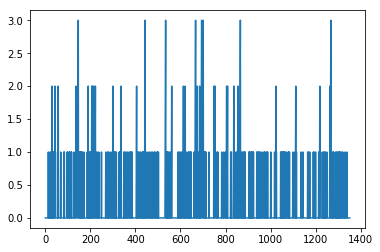

In [10]:
plt.plot(chain_timestamps[0])
plt.show()

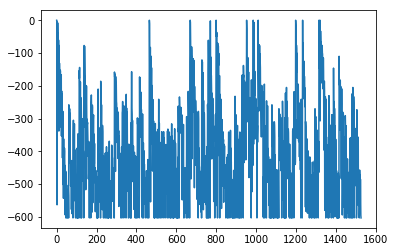

In [11]:
plt.plot(chain_timestamps[1])
plt.show()

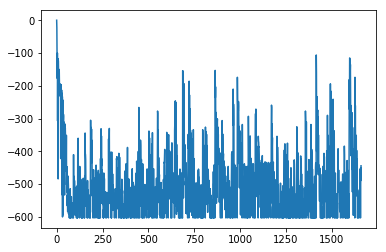

In [12]:
plt.plot(chain_timestamps[2])
plt.show()

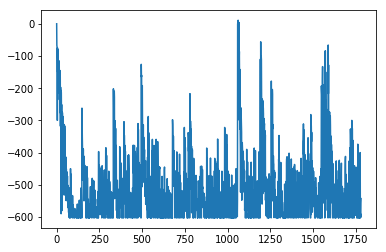

In [13]:
plt.plot(chain_timestamps[3])
plt.show()

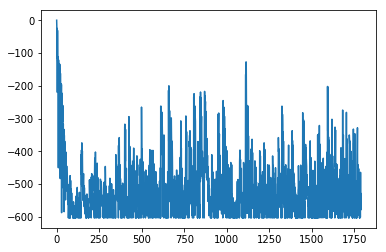

In [14]:
plt.plot(chain_timestamps[4])
plt.show()

In [15]:
# Lets try now with a bigger network, and a small greedy node.
# Trying parameters closer to what Particl has, just to see how it would behave there...
bignet = SimNet(
    simulation_time=172800,
    coins_amount=100000,
    num_coins_per_proposer=1,
    num_proposer_nodes=50,
    num_relay_nodes=75,
    num_greedy_proposers=1,
    time_between_blocks=120,
    block_time_mask=15,
    max_future_block_time_seconds=2 * 60 * 60
)

In [16]:
greedy_node = [n for n in bignet.nodes if n.is_proposer and n.greedy_proposal][0]

In [17]:
# We discard all the coins, but 1, for our greedy node, to decrease its stake
coin = list(greedy_node.coins_cache)[0]
coin = Coin(amount=coin.amount // 100, height=coin.height, txo=coin.txo)
greedy_node.coins_cache = {coin}
greedy_node.initial_coins = greedy_node.coins_cache.copy()
greedy_node.coins_cache

{Coin(amount=1000, height=0, txo=TransactionOutput(tx_hash=b'Nc\xcd\xbd6\x97\x14\xcaBU\xf7zI{8\x96T\x8c\x0c\xa4T\xd4^S\x84a\xdeu\xc2\xbc\x9f\xec', out_idx=35))}

In [ ]:
bignet.run()

In [7]:
print(
    f'height: {max(n.main_chain.height for n in bignet.nodes)}, '
    f'chain_work: {max(n.main_chain.get_chain_work() for n in bignet.nodes)}'
)

height: 1686, chain_work: 64904225496


In [8]:
1686 * 120

202320

In [9]:
greedy_funds = sum(
    sum(c.amount for c in n.coins_cache)
    for n in bignet.nodes
    if n.is_proposer and n.greedy_proposal
)


naive_funds = sum(
    sum(c.amount for c in n.coins_cache)
    for n in bignet.nodes
    if n.is_proposer and not n.greedy_proposal
)

print(
    f'num_greedy: {bignet.num_greedy_proposers}, '
    f'greedy_benefit: {greedy_funds - 1000}, '
    f'naive_benefit: {naive_funds - 4900000}'
)

num_greedy: 1, greedy_benefit: 26, naive_benefit: 1660


In [50]:
# The greedy proposer multiplies its probabilities by 79.85 when the naive nodes are extremely naive
# (they don't try to propose if the current time is lower than the past median block time)
26 / (1628 / 5000)  # we had 1628 blocks, and 26 units of benefit for the greedy node.

79.85257985257985

In [11]:
26 / (1686 / 5000)  # If nodes are slightly less naide, it still does not make any difference.

77.1055753262159

In [7]:
# Lets try now with a bigger network, and a small greedy node.
# Trying parameters closer ours now, just to see how it would behave there...
ournet = SimNet(
    simulation_time=172800,
    coins_amount=100000,
    num_coins_per_proposer=1,
    num_proposer_nodes=50,
    num_relay_nodes=75,
    num_greedy_proposers=1,
    time_between_blocks=16,
    block_time_mask=4,
    max_future_block_time_seconds=10 * 60  # The proposal is to have a "small" time window
)

greedy_node = [n for n in ournet.nodes if n.is_proposer and n.greedy_proposal][0]

# Tweaking the greedy node to decrease its stake
coin = list(greedy_node.coins_cache)[0]
coin = Coin(amount=coin.amount // 100, height=coin.height, txo=coin.txo)
greedy_node.coins_cache = {coin}
greedy_node.initial_coins = greedy_node.coins_cache.copy()
greedy_node.coins_cache

ournet.run()

In [8]:
print(
    f'height: {max(n.main_chain.height for n in ournet.nodes)}, '
    f'chain_work: {max(n.main_chain.get_chain_work() for n in ournet.nodes)}'
)

height: 10757, chain_work: 234266604998


In [9]:
16 * 10757, 48 * 3600

(172112, 172800)

In [10]:
greedy_funds = sum(
    sum(c.amount for c in n.coins_cache)
    for n in ournet.nodes
    if n.is_proposer and n.greedy_proposal
)


naive_funds = sum(
    sum(c.amount for c in n.coins_cache)
    for n in ournet.nodes
    if n.is_proposer and not n.greedy_proposal
)

print(
    f'num_greedy: {ournet.num_greedy_proposers}, '
    f'greedy_benefit: {greedy_funds - 1000}, '
    f'naive_benefit: {naive_funds - 4900000}'
)

num_greedy: 1, greedy_benefit: 83, naive_benefit: 10674


In [12]:
10757 / 5000  # That's the expected benefit for a naive node holding 1/5000 of the stake

2.1514

In [13]:
83 / 2.1514

38.579529608626935

In [14]:
# Now, let's examine the timestamps...
best_chain = sorted(
    [node.main_chain for node in ournet.nodes],
    key=lambda c: c.get_chain_work(),
    reverse=True
)[0]

chain_timestamps = [(block.real_timestamp - block.timestamp) for block in best_chain.blocks]

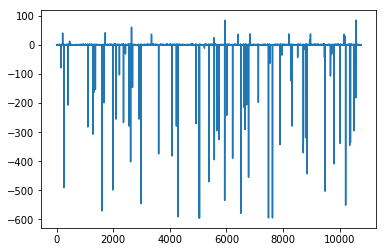

In [17]:
plt.plot(chain_timestamps)
plt.show()

In [18]:
# Saving the generated data for later, to save some time.
from pickle import dumps as pdumps

# Removing references to unserializable objects
ournet.logger = None
for node in ournet.nodes: 
    for block in node.main_chain.blocks: 
        block._kernel_hash_base = None 
        block._block_hash_base = None 
    for chain in node.alternative_chains: 
        for block in chain.blocks: 
            block._kernel_hash_base = None 
            block._block_hash_base = None

with open('./data/ournet_48h.dat', 'wb') as simulation_file:
    simulation_file.write(pdumps(ournet))
